# Forecasting Diaper Demand

Brendan Reed  
12/9/2025

### Import Packages

In [498]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

### Import Data

In [499]:
df = pd.read_csv("data/diapers.csv")

df.head()

,Timestamp,BRANCH,ZIP CODE,SIZE,# PACKS,SIZE.1,# PACKS.1,SIZE.2,# PACKS.2,TOTAL,DATE,MONTH,YEAR,DAY,WEEKDAY
0,9/7/2021 0:00:00,GG,63011,1,3.0,NaN,NaN,NaN,NaN,3,September 2021,September,2021,7,Tue
1,9/7/2021 0:00:00,GG,63011,3T,2.0,NaN,NaN,NaN,NaN,2,September 2021,September,2021,7,Tue
2,9/14/2021 0:00:00,GG,63118,5,2.0,NaN,NaN,NaN,NaN,2,September 2021,September,2021,14,Tue
3,9/14/2021 0:00:00,GG,63118,6,2.0,NaN,NaN,NaN,NaN,2,September 2021,September,2021,14,Tue
4,9/14/2021 0:00:00,GG,63125,5,2.0,NaN,NaN,NaN,NaN,2,September 2021,September,2021,14,Tue


In [500]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59425 entries, 0 to 59424
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  50120 non-null  object 
 1   BRANCH     50117 non-null  object 
 2   ZIP CODE   50113 non-null  object 
 3   SIZE       49967 non-null  object 
 4   # PACKS    50090 non-null  float64
 5   SIZE.1     7687 non-null   object 
 6   # PACKS.1  7595 non-null   float64
 7   SIZE.2     1648 non-null   object 
 8   # PACKS.2  2491 non-null   float64
 9   TOTAL      59425 non-null  int64  
 10  DATE       59425 non-null  object 
 11  MONTH      50120 non-null  object 
 12  YEAR       50120 non-null  object 
 13  DAY        50120 non-null  object 
 14  WEEKDAY    50120 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 6.8+ MB


## Cleaning Data

Choose only desired columns

In [501]:
df = df[[
    'Timestamp', 'BRANCH', 'ZIP CODE', 'SIZE', '# PACKS', 'SIZE.1',
    '# PACKS.1', 'SIZE.2', '# PACKS.2', 'TOTAL'
]]

Make all column names lower case

In [502]:
df.columns = [item.lower() for item in list(df.columns)]

Filter to only Weber Road

In [503]:
df = df[df['branch'] == "WR"]

Create a row for each pair of sizes and # packs

In [504]:
size_cols = ["size", "size.1", "size.2"]
pack_cols = ["# packs", "# packs.1", "# packs.2"]

pieces = []

for i in range(3):  # force 3 iterations
    temp = df[["timestamp", "branch", "zip code"]].copy()
    temp["size"] = df[size_cols[i]]
    temp["# packs"] = df[pack_cols[i]]
    pieces.append(temp)

df = pd.concat(pieces, ignore_index=True)


Drop rows where both size and # packs is NA

In [505]:
df = df.dropna(subset=["size", "# packs"], how="all")

Preview data

Check for missing values

In [506]:
pd.DataFrame({
    "NaN Count": df.isna().sum(),
    "Total Rows": len(df),
    "Percent NaN": df.isna().mean() * 100
})


,NaN Count,Total Rows,Percent NaN
timestamp,0,12506,0.000000
branch,0,12506,0.000000
zip code,4,12506,0.031985
size,444,12506,3.550296
# packs,25,12506,0.199904


Size is missing for 444 rows, which we will need to address. For now, I will leave missing values and see how prevalent they are across different months.

See unique sizes

In [507]:
df["size"].unique()

array(['6', '3', '4', 'n', '2', '3t', '1', '5', 'N', '3T', '2T', '2t',
       'adult', '4t', '4T', nan, '7'], dtype=object)

Some sizes have duplicates or are not valid.  
Fixes: 
- 'n' and 'N' need to be combined
- 2t and 2T need to be combined for pullups (same with 3t/3T and 4t/4T)
- size 7 needs to be added to nan (we do not give out size 7)

In [508]:
# cast all sizes to strings
df['size'] = df['size'].astype(str)

# make all letters in df["size"] upper case
df["size"] = [x.upper() for x in df["size"]]

# replace size 7 with "Not a Number"
df["size"] = df["size"].replace("7", "NAN")

Create date and month columns

In [509]:
# convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# create month column
df['month'] = df['timestamp'].dt.to_period('M')

# create date column
df['date'] = pd.to_datetime(df['timestamp']).dt.date

# remove timestamp column
df = df.drop('timestamp', axis=1)


Create pivot table to see totals for each size by month

In [510]:
# Replace real NaN in size with a category name
df['size_cat'] = df['size'].astype('object').fillna('NaN')

# Build pivot table
table = df.pivot_table(
    index='month',
    columns='size_cat',
    values='# packs',
    aggfunc='sum',
    fill_value=0,
    dropna=False
)

In [511]:
table.head()

size_cat,1,2,2T,3,3T,4,4T,5,6,ADULT,N,NAN
month,,,,,,,,,,,,
1902-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2021-09,9.0,15.0,0.0,18.0,6.0,24.0,0.0,20.0,16.0,0.0,15.0,0.0
2021-10,9.0,14.0,6.0,27.0,6.0,27.0,0.0,48.0,30.0,0.0,15.0,0.0
2021-11,14.0,28.0,2.0,39.0,2.0,34.0,0.0,44.0,42.0,0.0,12.0,0.0
2021-12,31.0,30.0,0.0,43.0,4.0,32.0,0.0,46.0,50.0,0.0,12.0,0.0


In [512]:
table['total'] = table.sum(axis=1)

# Total without NAN
table['adj total'] = table['total'] - table['NAN'] 

# month2 must have different name than month because month belongs to index
table['month2'] = table.index.month

table['year'] = table.index.year

# Total without NAN, pull-ups, and adult
table['adj total 2'] = table['total'] - (table['NAN'] + table['2T'] + table['3T'] + table['4T'] + table['ADULT'])

In [513]:
table.head()

size_cat,1,2,2T,3,3T,4,4T,5,6,ADULT,N,NAN,total,adj total,month2,year,adj total 2
month,,,,,,,,,,,,,,,,,
1902-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,10,1902,2.0
2021-09,9.0,15.0,0.0,18.0,6.0,24.0,0.0,20.0,16.0,0.0,15.0,0.0,123.0,123.0,9,2021,117.0
2021-10,9.0,14.0,6.0,27.0,6.0,27.0,0.0,48.0,30.0,0.0,15.0,0.0,182.0,182.0,10,2021,170.0
2021-11,14.0,28.0,2.0,39.0,2.0,34.0,0.0,44.0,42.0,0.0,12.0,0.0,217.0,217.0,11,2021,213.0
2021-12,31.0,30.0,0.0,43.0,4.0,32.0,0.0,46.0,50.0,0.0,12.0,0.0,248.0,248.0,12,2021,244.0


In [514]:
# filter to data from last 3 years
table_filtered = table[(table.index.year >=2023)].copy()

Drop December 2025 - incomplete data

In [515]:
table_filtered = table_filtered.loc[table_filtered.index != '2025-12-01']

In [516]:
# Convert PeriodIndex to Timestamp for plotting
table_filtered.index = table_filtered.index.to_timestamp()

In [517]:
# create NAN proportions column
table_filtered["NAN/total"] = round(table_filtered["NAN"] / table_filtered["total"], 2)

View rows with missing values

In [518]:
table_filtered[table_filtered["NAN/total"] > 0]

size_cat,1,2,2T,3,3T,4,4T,5,6,ADULT,N,NAN,total,adj total,month2,year,adj total 2,NAN/total
month,,,,,,,,,,,,,,,,,,
2024-06-01,11.0,11.0,6.0,32.0,10.0,63.0,6.0,72.0,100.0,0.0,2.0,31.0,344.0,313.0,6,2024,291.0,0.09
2024-07-01,18.0,11.0,7.0,26.0,5.0,65.0,4.0,57.0,108.0,0.0,7.0,40.0,348.0,308.0,7,2024,292.0,0.11
2024-08-01,10.0,12.0,9.0,50.0,9.0,66.0,10.0,87.0,90.0,0.0,3.0,46.0,392.0,346.0,8,2024,318.0,0.12
2024-09-01,8.0,6.0,8.0,32.0,10.0,40.0,9.0,76.0,117.0,0.0,3.0,31.0,340.0,309.0,9,2024,282.0,0.09
2024-10-01,9.0,11.0,6.0,20.0,9.0,32.0,13.0,76.0,96.0,0.0,3.0,42.0,317.0,275.0,10,2024,247.0,0.13
2024-11-01,10.0,8.0,6.0,26.0,4.0,22.0,9.0,65.0,84.0,0.0,5.0,24.0,263.0,239.0,11,2024,220.0,0.09
2024-12-01,13.0,9.0,8.0,16.0,10.0,41.0,10.0,102.0,50.0,0.0,3.0,17.0,279.0,262.0,12,2024,234.0,0.06
2025-01-01,6.0,10.0,9.0,21.0,10.0,49.0,10.0,34.0,97.0,0.0,5.0,19.0,270.0,251.0,1,2025,222.0,0.07
2025-02-01,6.0,9.0,3.0,19.0,5.0,44.0,8.0,56.0,80.0,0.0,8.0,29.0,267.0,238.0,2,2025,222.0,0.11


Rows for 2024-06-01 forward have missing values for size.

### Monthly Totals for Each Size

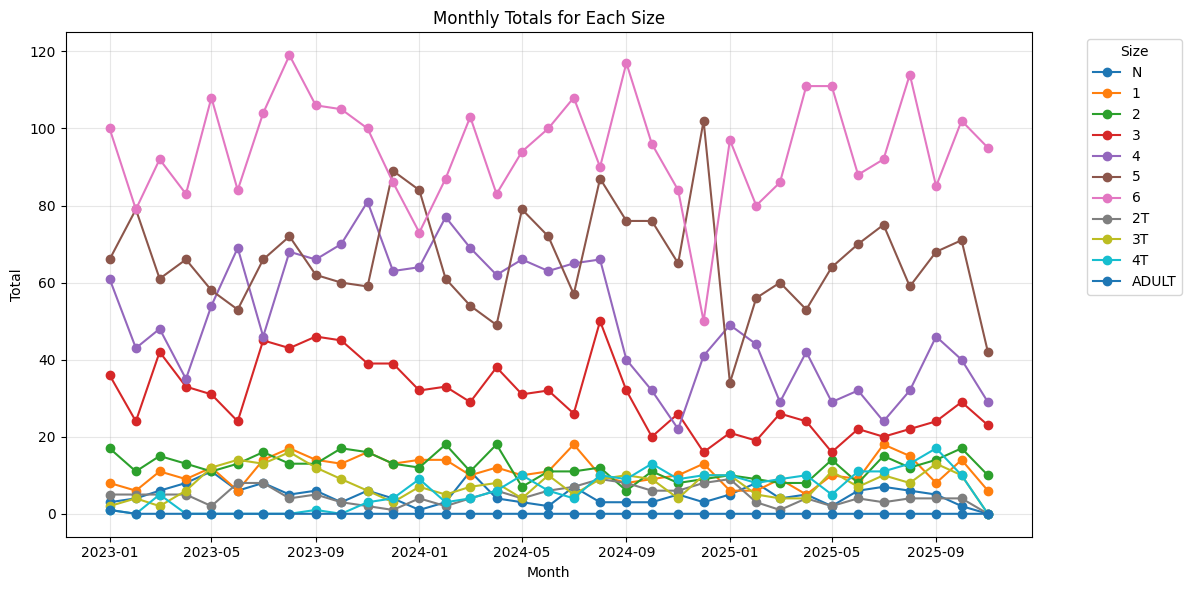

In [519]:
size_cols = ['N', '1', '2', '3', '4', '5', '6', '2T', '3T', '4T', 'ADULT']

plt.figure(figsize=(12,6))

for col in size_cols:
    plt.plot(table_filtered.index, table_filtered[col], marker='o', label=col)

plt.title('Monthly Totals for Each Size')
plt.xlabel('Month')
plt.ylabel('Total')
plt.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The values for size 5 and 6 for 2024-12-01 are outliers. The dramatic increase in size 5 and decrease in size 6 is likely because the branch ran out of size 6, and so people chose size 5 instead.  

I will drop this row in future calculations.

In [520]:
table_filtered.loc["2024-12-01",:].loc[["5","6"]].to_frame()

,2024-12-01
size_cat,
5,102.0
6,50.0


In [521]:
table_filtered = table_filtered[table_filtered.index != "2024-12-01"]

## Examining Proportions of Sizes

Create pivot table that shows proportions of each size to monthly totals

In [522]:
size_cols = ['N', '1', '2', '3', '4', '5', '6', '2T', '3T', '4T', 'ADULT']


# Create a new DataFrame for proportions
prop_table = table_filtered[size_cols].div(table_filtered['adj total'], axis=0)

# Round to 2 decimals for readability
prop_table = prop_table.round(2)

<Figure size 1200x600 with 0 Axes>

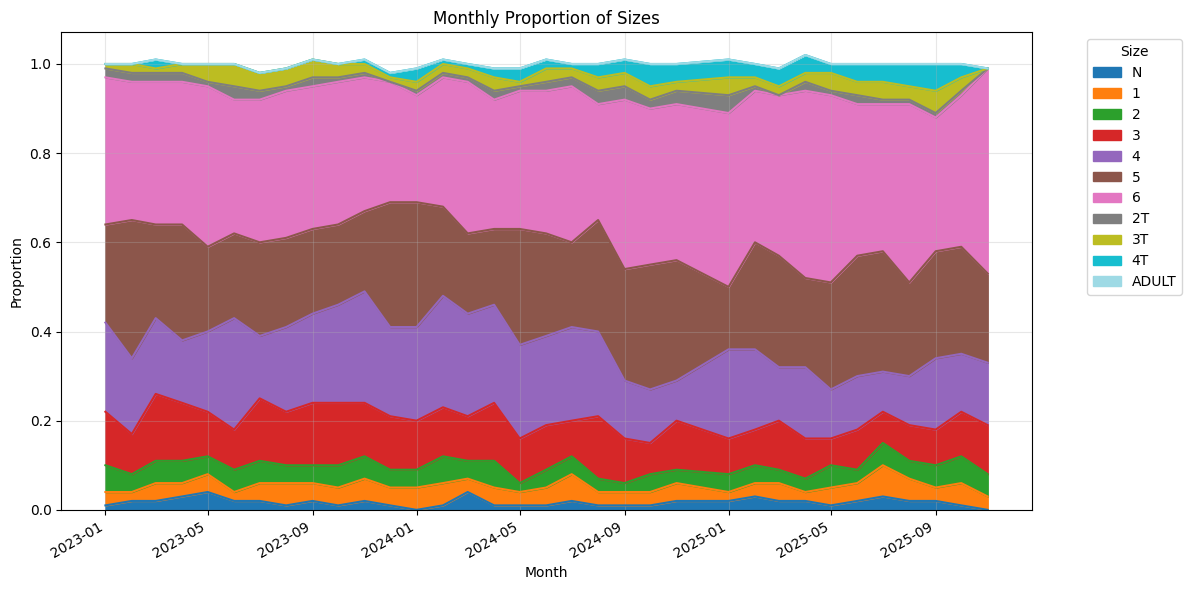

In [523]:
plt.figure(figsize=(12,6))

# stacked area plot
prop_table.plot(kind='area', stacked=True, figsize=(12,6), cmap='tab20')

plt.title('Monthly Proportion of Sizes')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [524]:
# Total area (sum of proportions over all months)
total_area = prop_table[size_cols].sum()

total_area_percent = (total_area / total_area.sum())

Overall diaper size proportions from 2023 - 2025

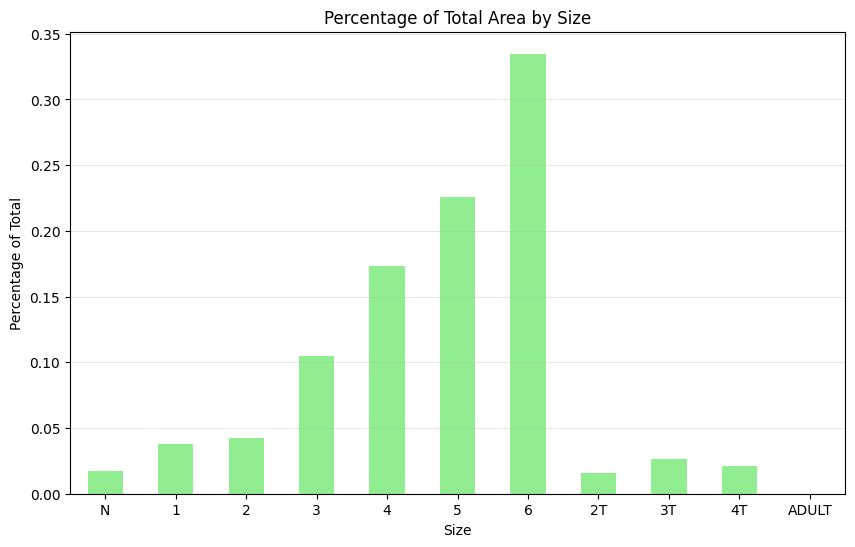

In [525]:
total_area_percent.plot(kind='bar', figsize=(10,6), color='lightgreen')

plt.title('Percentage of Total Area by Size')
plt.xlabel('Size')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


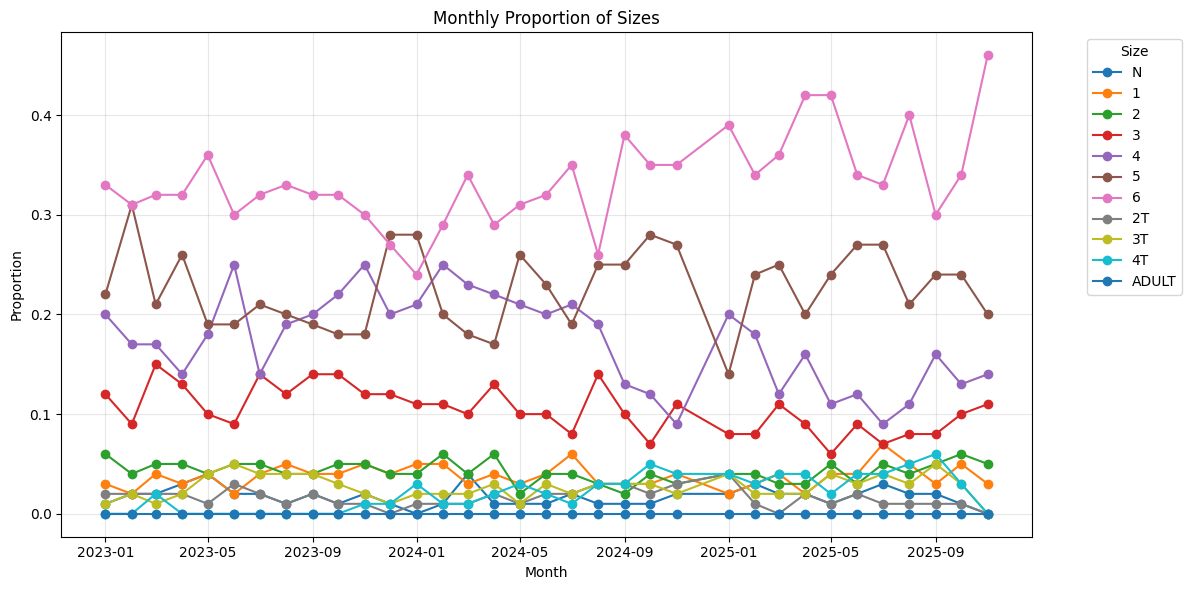

In [526]:
plt.figure(figsize=(12,6))

for col in size_cols:
    plt.plot(prop_table.index, prop_table[col], marker='o', label=col)

plt.title('Monthly Proportion of Sizes')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [527]:
prop_table.loc[["2023-01-01", "2025-11-01"],:]

size_cat,N,1,2,3,4,5,6,2T,3T,4T,ADULT
month,,,,,,,,,,,
2023-01-01,0.01,0.03,0.06,0.12,0.20,0.22,0.33,0.02,0.01,0.0,0.0
2025-11-01,0.00,0.03,0.05,0.11,0.14,0.20,0.46,0.00,0.00,0.0,0.0


### Conclusions:
Size 6 has seen an upward trend proportionally, while other sizes have seen downward trends. At some points, less size 6 diapers are given out than size 5. This is probably due to running out of size 6 and people choosing size 5 instead. For the biggest size 6 dip in late 2024, the data point could be removed and interpolated, which could improve forcasting.

Options for generalizing proportions to the future:
- Look at total proportions for only the last 12 months
- Try to predict linear trends in proportions  

Use cases:
- Proportions could be used to fill in missing values for diaper sizes
- After total diapers distributed is predicted for future months, the total can be multiplied with proportions for sizes to predict number of sizes given out each month

## Use proportions to estimate missing data

For total diaper sizes for each month, we can multiply NaN totals with the proportion of each diaper size given out that month to estimate how many of each diaper size was given out, but not correctly recorded.

In [528]:
size_cols = ['N', '1', '2', '3', '4', '5', '6', '2T', '3T', '4T', 'ADULT']

Only consider data from the last year.

In [529]:
df_orig = table_filtered.loc['2024-12-01':'2025-11-01']

In [530]:
proportions = df_orig[size_cols].div(df_orig['adj total'], axis=0).round(2)

In [531]:
result = proportions.mul(df_orig['NAN'], axis=0)
result = result.round(0)

Adjusted Monthly Totals

In [532]:
df_total = df_orig[size_cols] + result
df_total

size_cat,N,1,2,3,4,5,6,2T,3T,4T,ADULT
month,,,,,,,,,,,
2025-01-01,5.0,6.0,11.0,23.0,53.0,37.0,104.0,10.0,11.0,11.0,0.0
2025-02-01,9.0,7.0,10.0,21.0,49.0,63.0,90.0,3.0,6.0,9.0,0.0
2025-03-01,4.0,10.0,8.0,28.0,31.0,64.0,91.0,1.0,4.0,10.0,0.0
2025-04-01,6.0,6.0,9.0,27.0,46.0,59.0,123.0,5.0,5.0,11.0,0.0
2025-05-01,2.0,11.0,15.0,18.0,32.0,70.0,122.0,2.0,12.0,6.0,0.0
2025-06-01,6.0,10.0,9.0,24.0,34.0,75.0,94.0,4.0,8.0,12.0,0.0
2025-07-01,8.0,20.0,16.0,22.0,26.0,81.0,99.0,3.0,11.0,12.0,0.0
2025-08-01,7.0,16.0,13.0,24.0,35.0,65.0,126.0,4.0,9.0,14.0,0.0
2025-09-01,6.0,9.0,15.0,26.0,50.0,74.0,93.0,4.0,14.0,19.0,0.0


## Diaper Total Trends

Looks at trends for total number of diapers distributed each month.

In [533]:
totals_by_month = table_filtered.pivot_table(
    index='month2',
    columns='year',
    values='total',
    aggfunc='sum'
)

totals_by_month.loc[12,2025] = np.nan

In [534]:
totals_by_month
pivot = totals_by_month
pivot.head()

year,2023,2024,2025
month2,,,
1,300.0,300.0,270.0
2,255.0,303.0,267.0
3,287.0,302.0,250.0
4,258.0,286.0,294.0
5,299.0,308.0,290.0


Graph monthly totals by year to compare trends

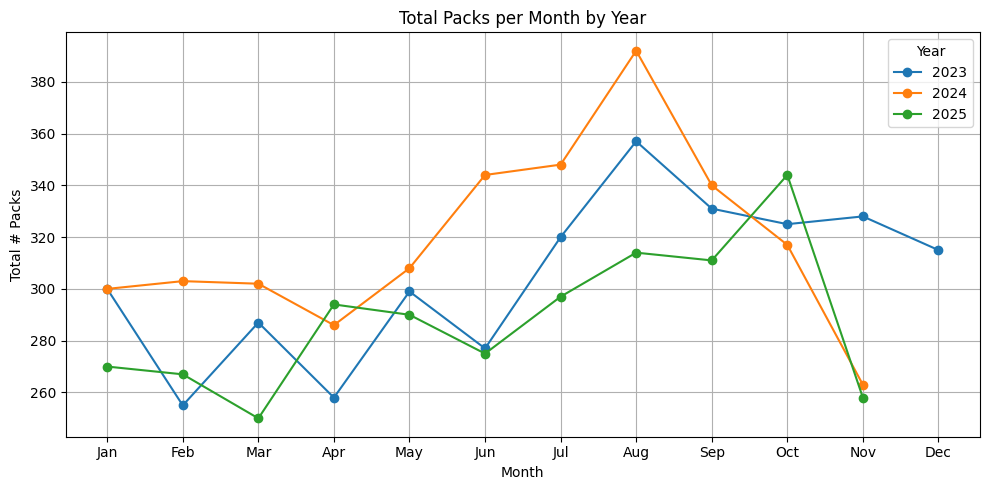

In [535]:
plt.figure(figsize=(10,5))
for year in totals_by_month.columns:
    plt.plot(totals_by_month.index, totals_by_month[year], marker='o', label=str(year))

plt.xlabel("Month")
plt.ylabel("Total # Packs")
plt.title("Total Packs per Month by Year")
plt.xticks(ticks=range(1,13), labels=[
    "Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"
])
plt.legend(title="Year")
plt.grid(True)
plt.tight_layout()
plt.show()


Conclusion: 2023, 2024, and 2025 follow similar seasonal trends. Totals increase in summer and decrease in winter.

## Forecasting Diaper Totals

### Modeling Total Diapers per Month

About holt-winters...

Deciding between Additive and Multiplicative

In [536]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Flatten table to time series (Month-Year index)
ts = pivot.stack()
ts.index = pd.date_range(start='2023-01-01', periods=len(ts), freq='MS')

# Additive Holt-Winters
model_add = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12).fit()

# Multiplicative Holt-Winters
model_mul = ExponentialSmoothing(ts, trend='add', seasonal='mul', seasonal_periods=12).fit()

print("Additive AIC:", model_add.aic)
print("Multiplicative AIC:", model_mul.aic)

Additive AIC: 243.19389632643384
Multiplicative AIC: 242.58402784021868


Conclusion: go with multiplicative

In [537]:
table_filtered.loc["2025-12-01","total"] = np.nan

In [538]:
# Create a pandas Series for the totals
ts = table_filtered["total"].sort_index()  # make sure sorted by date
ts = ts.interpolate(method='time')

c:\Users\reedb\Documents\Git Repos\Diapers\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\reedb\Documents\Git Repos\Diapers\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\reedb\Documents\Git Repos\Diapers\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


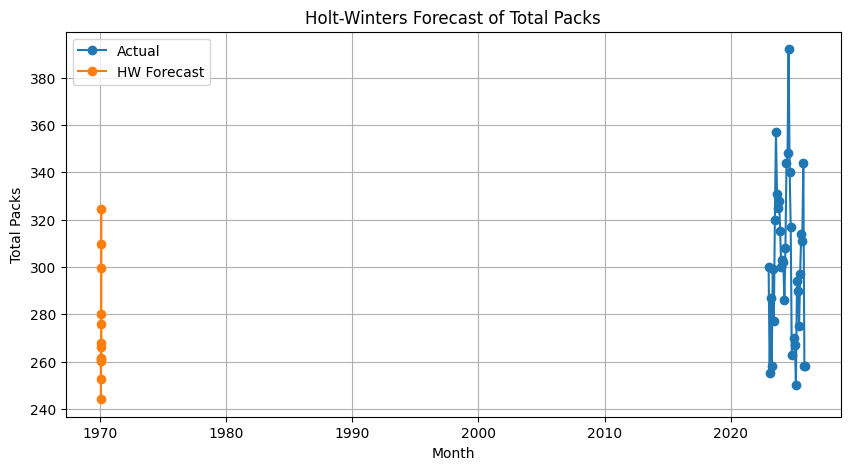

In [539]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Fit Holt-Winters seasonal model (monthly data, yearly seasonality)
hw_model = ExponentialSmoothing(ts, seasonal='mul', seasonal_periods=12)
hw_fit = hw_model.fit()

# Forecast next 12 months
hw_forecast = hw_fit.forecast(12)

# Plot
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts, label='Actual', marker='o')
plt.plot(hw_forecast.index, hw_forecast, label='HW Forecast', marker='o')
plt.title('Holt-Winters Forecast of Total Packs')
plt.xlabel('Month')
plt.ylabel('Total Packs')
plt.legend()
plt.grid(True)
plt.show()


## Storage

In [540]:
storage = pd.read_csv("data/storage.csv", index_col=0)

storage["Proportion"] = round(storage["Total"] / sum(storage["Total"]), 2)

storage = storage.loc["1":"6"]

In [541]:
size_cols = ['1', '2', '3', '4', '5', '6']

size_totals = df_total[size_cols].sum(axis=1)

prop_table = df_total[size_cols].div(size_totals, axis=0).round(2)

In [542]:
# Total area (sum of proportions over all months)
total_area = prop_table[size_cols].sum()

total_area_percent = round(total_area / total_area.sum(),2)

Find average packs per month given out

In [543]:
averages = [math.ceil(x) for x in df_total[size_cols].mean()]

In [544]:
storage["Est. Loss/Month"] = averages
storage["Est. Loss/Month Prop."] = total_area_percent

In [545]:
# storage[["Total", "Est. Loss/Month", "Proportion", "Est. Loss/Month Prop."]]

In [546]:
storage['New Stock'] = storage['Total'].sum() * storage["Est. Loss/Month Prop."]

In [547]:
storage['New Stock'] = [math.ceil(x) for x in storage['New Stock']]

In [548]:
storage

,Total,Proportion,Est. Loss/Month,Est. Loss/Month Prop.,New Stock
Shelf,,,,,
1,63,0.13,11,0.04,19
2,63,0.13,13,0.05,23
3,90,0.19,25,0.10,46
4,60,0.13,40,0.15,69
5,60,0.13,66,0.25,114
6,120,0.25,108,0.41,187


In [549]:
# table for how many months we could last with our shelves fully stocked
current = storage['Total']
current_months = round(storage['Total'] / storage['Est. Loss/Month'], 1)
new = storage["New Stock"]
new_months = round(storage["New Stock"] / storage['Est. Loss/Month'], 1)

stock = pd.DataFrame({
    'current': current,
    'current_months': current_months,
    'new': new,
    'new_months': new_months
})

stock


,current,current_months,new,new_months
Shelf,,,,
1,63,5.7,19,1.7
2,63,4.8,23,1.8
3,90,3.6,46,1.8
4,60,1.5,69,1.7
5,60,0.9,114,1.7
6,120,1.1,187,1.7


## Weekly Proportions

Look at weekly breakdowns

In [550]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [551]:
df['week_of_month'] = 1 + (df['date'].dt.day - 1) // 7

In [552]:
df['year'] = df['date'].dt.year
df['month_num'] = df['date'].dt.month

pivot = df.pivot_table(
    index=['year', 'month_num', 'week_of_month'],   # rows
    columns='size_cat',                              # size categories
    values='# packs',
    aggfunc='sum',
    fill_value=0
)


In [553]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [554]:
pivot_1yr = pivot.loc[(2025,1,1):(2025,11,5)].copy()
pivot_1yr["TOTAL"] = pivot_1yr.sum(axis=1)

In [555]:
# Assume your pivot_1yr table is called pivot_1yr
import pandas as pd

# Compute monthly totals of the TOTAL column
monthly_totals = pivot_1yr.groupby(level=['year','month_num'])['TOTAL'].transform('sum')

# Divide all size columns by monthly total to get proportion
size_columns = ['1','2','2T','3','3T','4','4T','5','6','ADULT','N','NAN']

# Create a new table with proportions
pivot_1yr_prop = pivot_1yr.copy()

# Optional: also include proportion of total per week
pivot_1yr_prop['TOTAL_prop'] = round(pivot_1yr['TOTAL'] / monthly_totals,2)




In [556]:
pivot_1yr_prop.head()

size_cat                        1    2   2T    3   3T     4   4T     5     6  \
year month_num week_of_month                                                   
2025 1         1              0.0  2.0  2.0  2.0  2.0   4.0  2.0  10.0  24.0   
               2              3.0  3.0  0.0  2.0  0.0  11.0  2.0  12.0  35.0   
               3              1.0  0.0  6.0  7.0  0.0  14.0  1.0   1.0   5.0   
               4              0.0  1.0  1.0  6.0  8.0  12.0  5.0   4.0  13.0   
               5              2.0  4.0  0.0  4.0  0.0   8.0  0.0   7.0  20.0   

size_cat                      ADULT    N  NAN  TOTAL  TOTAL_prop  
year month_num week_of_month                                      
2025 1         1                0.0  0.0  0.0   48.0        0.18  
               2                0.0  2.0  9.0   79.0        0.29  
               3                0.0  1.0  2.0   38.0        0.14  
               4                0.0  2.0  3.0   55.0        0.20  
               5                0.0  0.0  5.0   50.0        0.19

In [557]:
s = pivot_1yr_prop['TOTAL_prop']
temp_df = s.reset_index()
temp_df.columns = ['year', 'month_num', 'week_of_month', 'value']  # rename columns
temp_df['month_part'] = temp_df['week_of_month'].apply(lambda x: 1 if x in [1, 2] else 2)

In [558]:
# Assuming your DataFrame is called df
pivot_month_halves = pd.pivot_table(
    temp_df,
    index=['year', 'month_num', 'month_part'],
    values='value',
    aggfunc='sum'
).reset_index()

pivot_month_halves.head()


,year,month_num,month_part,value
0,2025,1,1,0.47
1,2025,1,2,0.53
2,2025,2,1,0.59
3,2025,2,2,0.40
4,2025,3,1,0.55


In [559]:
pivot = pd.pivot_table(
    pivot_month_halves,
    index=["month_part"],
    values='value',
    aggfunc='mean'
)

pivot.head()


,value
month_part,
1,0.580000
2,0.415455


<b>Look at Model + ratios to see how it would have performed on stock historically</b>

## Forecasting Distribution by Size

Using ratios...

In [560]:
proportions

# Total area (sum of proportions over all months)
total_area = proportions.sum()

total_area_percent = (total_area / total_area.sum())

In [561]:
df_total_sum = df_total.sum(axis=1)

In [562]:
result = []
for i in df_total_sum:
    row = []
    for j in total_area_percent:
        row.append(round(i * j,0))
    result.append(row)

In [563]:
predicted_totals = pd.DataFrame(result, columns=df_total.columns, index=df_total.index)

In [564]:
predicted_totals

size_cat,N,1,2,3,4,5,6,2T,3T,4T,ADULT
month,,,,,,,,,,,
2025-01-01,5.0,10.0,12.0,23.0,37.0,62.0,101.0,3.0,8.0,10.0,0.0
2025-02-01,5.0,10.0,11.0,23.0,37.0,61.0,99.0,3.0,8.0,9.0,0.0
2025-03-01,5.0,10.0,11.0,22.0,35.0,57.0,93.0,3.0,7.0,9.0,0.0
2025-04-01,5.0,11.0,13.0,26.0,41.0,67.0,111.0,4.0,9.0,11.0,0.0
2025-05-01,5.0,11.0,12.0,25.0,40.0,66.0,108.0,4.0,8.0,10.0,0.0
2025-06-01,5.0,11.0,12.0,24.0,38.0,63.0,103.0,4.0,8.0,10.0,0.0
2025-07-01,5.0,11.0,13.0,26.0,41.0,68.0,111.0,4.0,9.0,11.0,0.0
2025-08-01,6.0,12.0,13.0,27.0,43.0,71.0,117.0,4.0,9.0,11.0,0.0
2025-09-01,6.0,12.0,13.0,27.0,43.0,70.0,115.0,4.0,9.0,11.0,0.0


In [565]:
performance = predicted_totals - df_total
performance

size_cat,N,1,2,3,4,5,6,2T,3T,4T,ADULT
month,,,,,,,,,,,
2025-01-01,0.0,4.0,1.0,0.0,-16.0,25.0,-3.0,-7.0,-3.0,-1.0,0.0
2025-02-01,-4.0,3.0,1.0,2.0,-12.0,-2.0,9.0,0.0,2.0,0.0,0.0
2025-03-01,1.0,0.0,3.0,-6.0,4.0,-7.0,2.0,2.0,3.0,-1.0,0.0
2025-04-01,-1.0,5.0,4.0,-1.0,-5.0,8.0,-12.0,-1.0,4.0,0.0,0.0
2025-05-01,3.0,0.0,-3.0,7.0,8.0,-4.0,-14.0,2.0,-4.0,4.0,0.0
2025-06-01,-1.0,1.0,3.0,0.0,4.0,-12.0,9.0,0.0,0.0,-2.0,0.0
2025-07-01,-3.0,-9.0,-3.0,4.0,15.0,-13.0,12.0,1.0,-2.0,-1.0,0.0
2025-08-01,-1.0,-4.0,0.0,3.0,8.0,6.0,-9.0,0.0,0.0,-3.0,0.0
2025-09-01,0.0,3.0,-2.0,1.0,-7.0,-4.0,22.0,0.0,-5.0,-8.0,0.0


Try stock - df_total to see how we would do during the month

## Placing Diaper Orders

For reordering:
- reorder after week 2
- reorder the diapers given out the first 2 weeks, plus diapers predicted to be given out the rest of the month
- use ratios and predicted totals

Questions:
- are ratios consistent from first half to second half?

size_cat,N,1,2,3,4,5,6,2T,3T,4T,ADULT
month,,,,,,,,,,,
2025-01-01,5.0,6.0,10.0,21.0,49.0,34.0,97.0,9.0,10.0,10.0,0.0
2025-02-01,8.0,6.0,9.0,19.0,44.0,56.0,80.0,3.0,5.0,8.0,0.0
2025-03-01,4.0,9.0,8.0,26.0,29.0,60.0,86.0,1.0,4.0,9.0,0.0
2025-04-01,5.0,5.0,8.0,24.0,42.0,53.0,111.0,4.0,4.0,10.0,0.0
2025-05-01,2.0,10.0,14.0,16.0,29.0,64.0,111.0,2.0,11.0,5.0,0.0
2025-06-01,6.0,9.0,8.0,22.0,32.0,70.0,88.0,4.0,7.0,11.0,0.0
2025-07-01,7.0,18.0,15.0,20.0,24.0,75.0,92.0,3.0,10.0,11.0,0.0
2025-08-01,6.0,15.0,12.0,22.0,32.0,59.0,114.0,4.0,8.0,13.0,0.0
2025-09-01,5.0,8.0,14.0,24.0,46.0,68.0,85.0,4.0,13.0,17.0,0.0
